# Translator - Transformer
## Using the transformer Architectures from the paper: Attention is all you need
https://arxiv.org/pdf/1706.03762.pdf
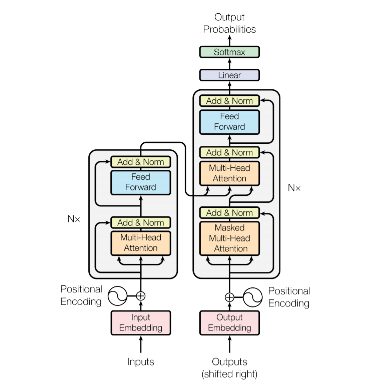

In [1]:
import numpy as np
import math
import re
import time
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [2]:
def open_files():
    with open(
    '../../../datasets/pt-en/europarl-v7.pt-en.en',
    mode = 'r',
    encoding = 'utf-8' 
    ) as file:
        data_en = file.read()

    with open(
        '../../../datasets/pt-en/europarl-v7.pt-en.pt',
        mode = 'r',
        encoding = 'utf-8' 
    ) as file:
        data_pt = file.read()
    return data_en, data_pt

## Cleaning data

In [3]:
def get_clean_corpus(data):
    corpus = data
    corpus = re.sub(r"\.(?=[0-9|[a-z]|[A-Z]])", ".###", corpus)
    corpus = re.sub(r"\.###","", corpus)
    corpus = re.sub(r" +", " ", corpus )
    corpus = corpus.split("\n")
    return corpus

## Tokenizing

In [4]:
def tokenizing(corpus_en, corpus_pt):
    vocab_size = 2**13 # 8192
    tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(corpus_en, target_vocab_size=vocab_size)
    tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(corpus_pt, target_vocab_size=vocab_size)
    return tokenizer_en, tokenizer_pt

In [5]:
def get_vocab_sizes(tokenizer_en, tokenizer_pt):
    VOCAB_SIZE_EN = tokenizer_en.vocab_size + 2
    VOCAB_SIZE_PT = tokenizer_pt.vocab_size + 2
    return VOCAB_SIZE_EN, VOCAB_SIZE_PT

In [6]:
def get_inputs_and_outputs(tokenizer_en, tokenizer_pt, corpus_en, corpus_pt, VOCAB_SIZE_EN, VOCAB_SIZE_PT):
    inputs = [
        [VOCAB_SIZE_EN - 2] + tokenizer_en.encode(sentence) + [VOCAB_SIZE_EN - 1]
        for sentence in corpus_en
    ]

    outputs = [
        [VOCAB_SIZE_PT - 2] + tokenizer_pt.encode(sentence) + [VOCAB_SIZE_PT - 1]
        for sentence in corpus_pt
    ]
    return inputs , outputs

## Removing too long sentences

In [7]:
MAX_LENGTH = 20
def remove_too_long_sentences(inputs, outputs):
    idx_to_remove = [
        count for count, sentence in enumerate(inputs)
        if len(sentence) > MAX_LENGTH
    ]

    for idx in reversed(idx_to_remove):
        del inputs[idx]
        del outputs[idx]

    idx_to_remove = [
        count for count, sentence in enumerate(outputs)
        if len(sentence) > MAX_LENGTH
    ]

    for idx in reversed(idx_to_remove):
        del inputs[idx]
        del outputs[idx]
    return inputs, outputs

## Saving input and output data for futher process

In [8]:
import pickle

def save_data (data, name = 'data.file'):
    with open(name, 'wb') as data_file:
        pickle.dump(data, data_file)
        
def load_data(name = 'data.file'):
    with open(name, 'rb') as data_file:
        data = pickle.load(data_file)
    return data

In [9]:
def pre_process_and_save(input_file_name= "", output_file_name=""):
    data_en, data_pt = open_files()
    corpus_en = get_clean_corpus(data_en)
    corpus_pt = get_clean_corpus(data_pt)
    tokenizer_en, tokenizer_pt = tokenizing(corpus_en, corpus_pt)
    VOCAB_SIZE_EN, VOCAB_SIZE_PT = get_vocab_sizes(tokenizer_en, tokenizer_pt)
    inputs , outputs = get_inputs_and_outputs(tokenizer_en, tokenizer_pt, corpus_en, corpus_pt, VOCAB_SIZE_EN, VOCAB_SIZE_PT)
    inputs , outputs = remove_too_long_sentences(inputs, outputs)
    save_data(inputs, input_file_name)
    save_data(outputs, output_file_name)

### Checkpoint (pre processing)

In [10]:
CHECKPOINT_INPUT_FILE_NAME_PRE_PROCESS = 'inputs_pre_process.dat'
CHECKPOINT_OUTPUT_FILE_NAME_PRE_PROCESS = 'outputs_pre_process.dat'

try:
    rec_inputs = load_data(CHECKPOINT_INPUT_FILE_NAME_PRE_PROCESS)
    rec_outputs = load_data(CHECKPOINT_OUTPUT_FILE_NAME_PRE_PROCESS)
    print('recovered sizes (inputs) (outputs) ', len(rec_inputs), len(rec_outputs))
except:
    print('creating pre processin checkpoint...')
    pre_process_and_save(CHECKPOINT_INPUT_FILE_NAME_PRE_PROCESS, CHECKPOINT_OUTPUT_FILE_NAME_PRE_PROCESS)
    rec_inputs = load_data(CHECKPOINT_INPUT_FILE_NAME_PRE_PROCESS)
    rec_outputs = load_data(CHECKPOINT_OUTPUT_FILE_NAME_PRE_PROCESS)
    print('recovered sizes (inputs) (outputs) ', len(rec_inputs), len(rec_outputs))

inputs = rec_inputs
outputs = rec_outputs

recovered sizes (inputs) (outputs)  396085 396085


## Padding

In [11]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(
    rec_inputs, 
    value=0,
    padding='post',
    maxlen=20
)

outputs = tf.keras.preprocessing.sequence.pad_sequences(
    rec_outputs, 
    value=0,
    padding='post',
    maxlen=20
)

## Build Dataset

In [12]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Build Model

### Embedding

### Positional encoding formulae:

### $PE_{(pos,2i)} =\sin(pos/10000^{2i/dmodel})$ (even numbers)

### $PE_{(pos,2i+1)} =\cos(pos/10000^{2i/dmodel})$ (odd numbers)

In [13]:
class PositionalEncoding(layers.Layer):
    
    def __init__(self):
        super(PositionalEncoding, self).__init__()
        
    def get_angles(self, pos, i, d_model):
        angles = 1 / np.power(
            10000., 
            (2 * (i/2) / np.float32(d_model) )
        )
        return pos * angles
    
    def call(self, inputs):
        inputs_shape_list = inputs.shape.as_list()
        seq_length = inputs_shape_list[-2]
        d_model = inputs_shape_list[-1]
        pos = np.arange(seq_length)[:, np.newaxis]                            
        i = np.arange(d_model)[np.newaxis, :]
        angles = self.get_angles(pos,i,d_model)
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        pos_encoding = angles[np.newaxis, ...]
        return inputs + tf.cast(pos_encoding, tf.float32)
            

### Attention

In [14]:
def scaled_dot_product_attention(queries, keys, values, mask):
    product = tf.matmul(queries, keys, transpose_b=True)
    keys_dimmention = tv.cast(tf.shape(keys)[-1], tf.float32)
    scaled_product = product / tf.math.sqrt(keys_dimmention)
    if mask is not None:
        scaled_product += (mask * -1e9)
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=1), values)
    return attention

In [15]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, number_of_projection):
        super(MultHeadAttention, self).__init__()
        self.number_of_projection = number_of_projection 
    
    # this method is called at the first time the object is use
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # assert the integers result in zero
        assert self.d_model % self.number_of_projection == 0
        # assure integer result
        self.d_proj = self.d_model // self.number_of_projection
        # create the dense layers
        self.query_linear_func = layers.Dense(units=self.d_model)
        self.keys_linear_func = layers.Dense(units=self.d_model)
        self.value_linear_func = layers.Dense(units=self.d_model)
        self.final_linear_func = layers.Dense(units = self.d_model)
        
    def split_projections(self, values, batch_size):
        shape = (batch_size,
                -1,
                self.number_of_projection,
                self.d_proj)
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, number_of_projections, d_proj)
        # shifting the 2nd and 3rd args
        splited_inputs = tf.transpose(splited_inputs, perm=[0,2,1,3]) # (batch_size, number_of_projections, seq_length,  d_proj)
        return splited_inputs
    
    def call(self, queries, keys, values, mask):
        batch_size = tf.shape(queries)[0]
        # build the dense layers
        queries = self.query_linear_func(queries)
        keys = self.keys_linear_func(keys)
        values = self.value_linear_func(values)
        # split the inputs
        queries = self.split_projections(queries, batch_size)
        keys = self.split_projections(keys, batch_size)
        values = self.split_projections(values, batch_size)
        attention = scaled_dot_product_attention(queries, keys,values, mask)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, shape=(
            batch_size,
            -1,
            self.d_model
        ))
        outputs = self.final_linear_func(concat_attention)
        return outputs

In [16]:
class EncoderLayer(layers.Layer):
    def __init__(self, 
                 FFN_units, 
                 number_of_projections, 
                 dropout_rate):
        super(EncoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.number_of_projections = number_of_projections
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        self.multi_head_attention = MultiHeadAttention(self.number_of_projections)
        self.dropout_and_norm_layers = []
        self.dropout_1 = layers.Dropout(rate = self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.dense_1 = layers.Dense(units= self.FFN_units, activation = 'relu')
        self.dense_2 = layers.Dense(units = self.d_model)
        self.dropout_2 = layers.Dropout(rate = self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training=False):
        attention = self.multi_head_attention(inputs,
                                             inputs,
                                             inputs,
                                             mask)
        attention = self.dropout_1(attention, training = training)
        attention = self.norm_1(attention + inputs)
        
        outputs = self.dense_1(attention)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_2(outputs)
        outputs = self.norm_2(outputs + attention)
        
        return outputs
    

In [19]:
class Encoder(layers.Layer):
    
    def __init__(self,
                number_of_layers,
                FFN_units,
                number_of_projections,
                dropout_rate,
                vocab_size,
                d_model,
                name = 'encoder'):
        super(Encoder, self).__init__(name = name)
        self.number_of_layers = number_of_layers
        self.d_model = d_model
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate = dropout_rate)
        self.enc_layers = [EncoderLayer(
            FFN_units,
            number_of_projections,
            dropout_rate
        ) for _ in range(number_of_layers)]
        
        
    def call(self, inputs, mask, training):
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(
            tf.cast(self.d_model, tf.float32)
        )
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        
        for i in range(self.number_of_layers):
            outputs = self.enc_layers[i](outputs, mask, training)
        
        return outputs

In [22]:
class DecoderLayer(layers.Layer):
    def __init__(self, FFN_units, number_of_projections, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.number_of_projections = number_of_projections
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.de_model = input_shape[-1]

        self.multi_head_attention_l1 = MultiHeadAttention(self.number_of_projections)
        self.dropout_l1 = layers.Dropout(rate=self.dropout_rate)
        self.nomalization_l1 = layers.LayerNomalization(epsilon=1e-6)

        self.multi_head_attention_l2 = MultiHeadAttention(self.number_of_projections)
        self.dropout_l2 = layers.Dropout(rate=self.dropout_rate)
        self.nomalization_l2 = layers.LayerNomalization(epsilon=1e-6)

        self.dense_l1 = layers.Dense(units=self.FFN_units, activation="relu")
        self.dense_l2 = layers.Dense(units=self.d_model)
        self.dropout_l3 = layers.Dropout(rate=self.dropout_rate)
        self.nomalization_l3 = layers.LayerNomalization(epsilon=1e-6)

    def call(
        self, inputs, encoder_outputs, mask_first_layer, mask_outputs_layer, is_training
    ):
        attention = self.multi_head_attention_l1(inputs, inputs, mask_first_layer)
        attention = self.dropout_l1(attention, is_training)
        attention = self.nomalization_l1(attention + inputs)

        attention2 = self.multi_head_attention_l2(
            attention, encoder_outputs, encoder_outputs, mask_outputs_layer
        )
        attention2 = self.dropout_l1(attention2, is_training)
        attention2 = self.nomalization_l1(attention2 + inputs)

        outputs = self.dense_l1(attention2)
        outputs = self.dense_l2(outputs)
        outputs = self.dropout_l3(outputs, is_training)
        outputs = self.nomalization_l3(outputs + attention)

        return outputs

In [23]:
class Decoder(layers.Layer):
    def __init__(
        self,
        number_of_layers,
        FFN_units,
        number_of_projections,
        dropout_rate,
        vocab_size,
        d_model,
        name="decoder",
    ):
        super(Decoder, self).__init__(name=name)
        self.number_of_layers = number_of_layers
        self.d_model = d_model
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.decoding_layers = [
            DecoderLayer(FFN_units, number_of_projections, dropout_rate)
            for _ in range(number_of_layers)
        ]

    def call(
        self, inputs, encoder_outputs, mask_first_layer, mask_outputs_layer, is_training
    ):
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, is_training)

        for i in range(self.number_of_layers):
            outputs = self.decoding_layers[i](
                outputs, mask_first_layer, mask_outputs_layer, is_training
            )

        return outputs